# Dinamična analiza #

In [27]:
import lvm_read
import numpy  as np
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import get_window
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import make_interp_spline, BSpline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 9]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
plt.rcParams.update({'text.usetex': True,
                     'font.size': 31,
                     'font.family':'lmodern',})

In [28]:
class MeritevDinamike():
    ''' Take a .lvm file for analysis of ROC. '''
    def __init__(self, read_data):
        self.data = lvm_read.read(read_data)
    
    def sig(self):
        '''Returns signal[0] and signal length[1] of class Meritev.'''
        sig = self.data[0]['data'][:,0]
        N = len(sig)
        return sig, N

    def time(self):
        '''Returns dt[0], fs[1] and total time[2] of class Meritev.'''
        sig = self.data[0]['data'][:,0]
        N = len(sig)
        dt = self.data[0]['Delta_X'][0]
        fs = 1 / dt
        cajt = dt * np.arange(N)
        return dt, fs, cajt
    
    def instruments(self):
        '''
        Returns instrument data of measurment Class:
        0 - Vhodni pospeškomer [g]
        1 - Izhodni silomer [N]
        2 - Napetost segrevanja [V]
        3 - Tok segrevanja [mA]
        4 - Upornost [Ohm] 
        5 - Temperatura termočlena 
        '''
        # Pospešek
        acc = self.data[0]['data'][:,0]
        # Sila
        force = self.data[0]['data'][:,1]
        # Tok
        curr_in = self.data[0]['data'][:,3]
        curr = curr_in/1.1 *1000 #mA
        # Napetost
        volt_in = self.data[0]['data'][:,2]
        volt = volt_in/0.09007 - curr_in
        # Upornost 
        res = volt/(curr/1000)
        # Temperatura
        temp = self.data[0]['data'][:,4]
        
        return acc, force, volt, curr, res, temp

    
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

## Prenosnost $T(\omega)$ z numeriko ##

###  $T(\omega)$ za ROC=3 (prikaz deformacij in nihanj na MKE modelom)  ###

In [29]:
## 3 ROC ##
# numerični model
ff = np.loadtxt("Mathematica/3ROC_single/FRF_MM_4,9mm/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re = np.loadtxt("Mathematica/3ROC_single/FRF_MM_4,9mm/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im = np.loadtxt("Mathematica/3ROC_single/FRF_MM_4,9mm/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin = np.loadtxt("Mathematica/3ROC_single/FRF_MM_4,9mm/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin = np.loadtxt("Mathematica/3ROC_single/FRF_MM_4,9mm/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin = np.loadtxt("Mathematica/3ROC_single/FRF_MM_4,9mm/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)
# numerični model (zoom)
ffgap = np.loadtxt("Mathematica/3ROC_single/FRF_MM_4,9mm/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re = np.loadtxt("Mathematica/3ROC_single/FRF_MM_4,9mm/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im = np.loadtxt("Mathematica/3ROC_single/FRF_MM_4,9mm/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran (zoom)
ffgap_lin = np.loadtxt("Mathematica/3ROC_single/FRF_MM_4,9mm/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_lin = np.loadtxt("Mathematica/3ROC_single/FRF_MM_4,9mm/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_lin = np.loadtxt("Mathematica/3ROC_single/FRF_MM_4,9mm/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

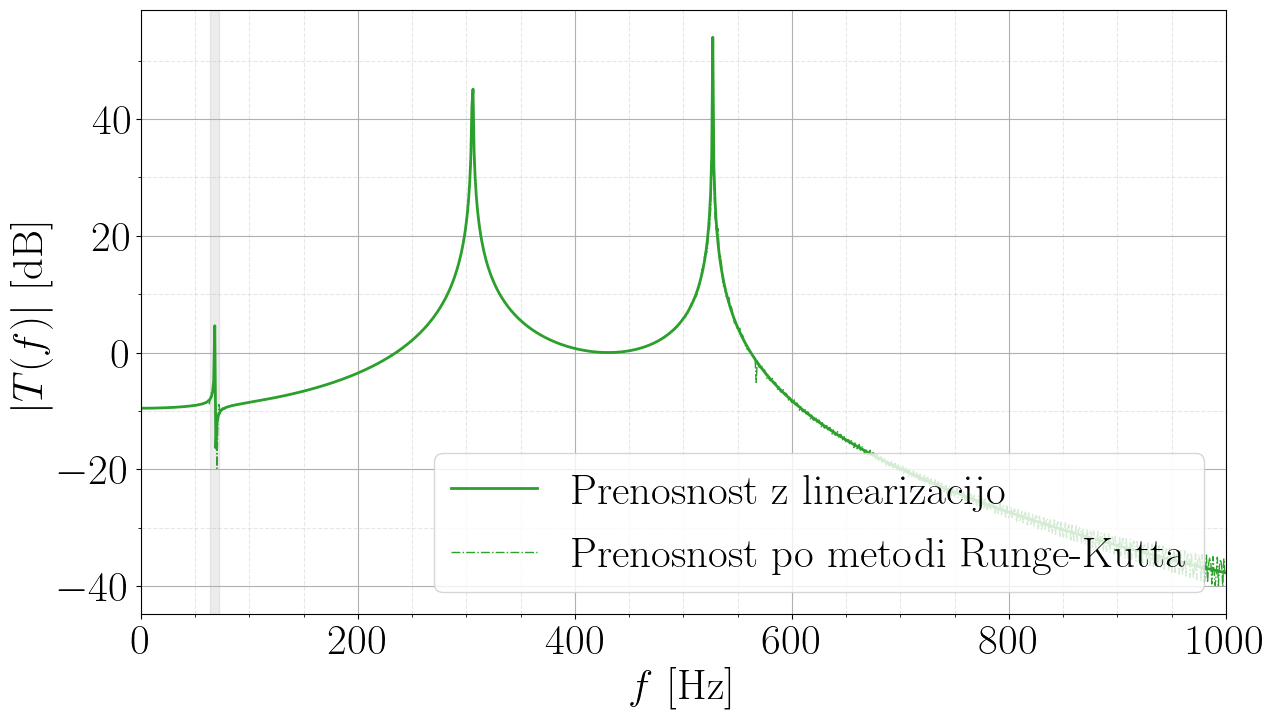

In [30]:
### Izris Abs(T)
plt.rcParams['figure.figsize'] = [14, 8]

# Numerika Mathematica

#ROC3
plt.plot(ff_lin, 20 * np.log10(np.abs(ft_Re_lin + ft_Im_lin*1j)), 
         linestyle="-", lw=2, color='tab:green', label=r'Prenosnost z linearizacijo')
plt.plot(ff, 20 * np.log10(np.abs(ft_Re + ft_Im*1j)), 
         linestyle="-.", lw=1, color='tab:green', label=r'Prenosnost po metodi Runge-Kutta')

plt.axvspan(64, 72, alpha=0.15, color='grey')


plt.xlabel(r'$f $ [Hz]')
plt.ylabel(r'$|T(f)|$ [dB]')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=8)
plt.xlim(0, 1000)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.legend(loc='lower right')
plt.savefig('T_3ROC_1.pdf', format='pdf')
plt.show()

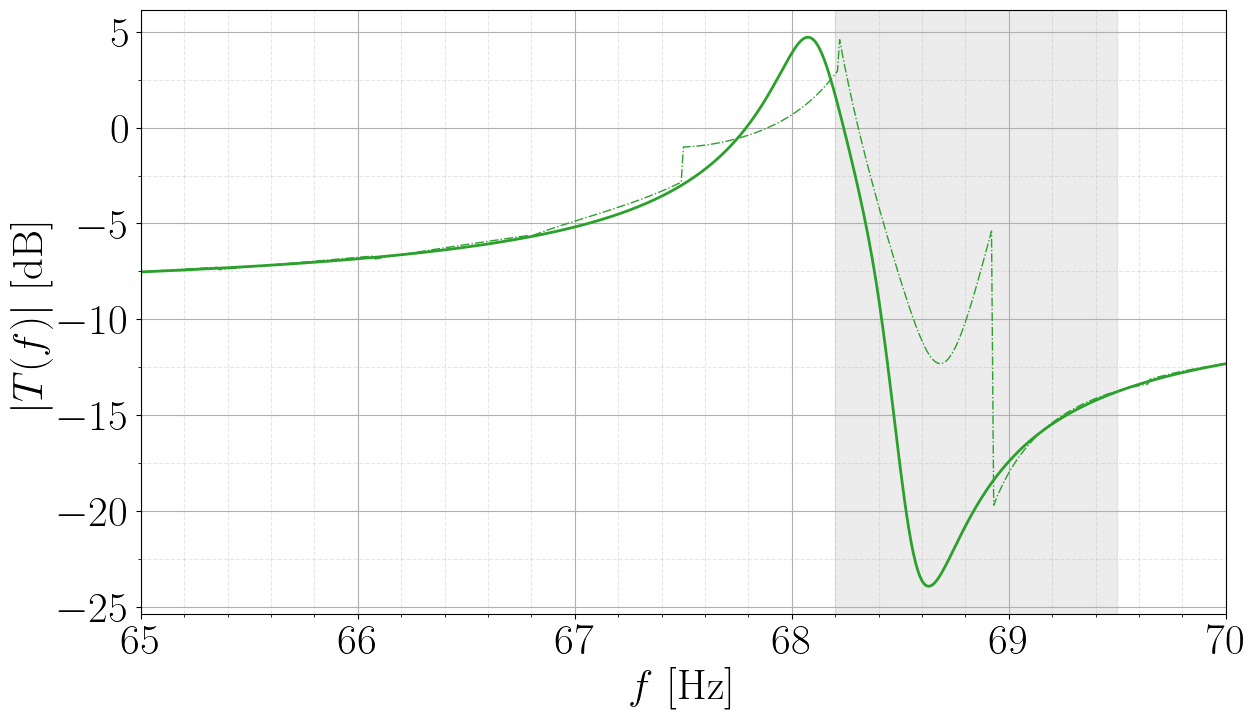

In [31]:
### Izris Abs(T) pobližano
# Numerika Mathematica

#ROC3
plt.plot(ffgap_lin, 20 * np.log10(np.abs(ftgap_Re_lin + ftgap_Im_lin*1j)), 
         linestyle="-", lw=2, color='tab:green')
plt.plot(ffgap, 20 * np.log10(np.abs(ftgap_Re + ftgap_Im*1j)), 
         linestyle="-.", lw=1, color='tab:green')


plt.axvspan(68.2, 69.5, alpha=0.15, color='grey')


plt.xlabel(r'$f $ [Hz]')
plt.ylabel(r'$|T(f)|$ [dB]')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=8)
plt.xlim(65, 70)
#plt.ylim(-50, 50)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.savefig('T_3ROC_2.pdf', format='pdf')
plt.show()

### FRF pri različnem št. ROC v MM (za območje KNT) ###

In [32]:
### import Mathematica ###

## 3 ROC ##
# numerični model
ff_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)
# numerični model (zoom)
ffgap_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran (zoom)
ffgap_lin_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_lin_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_lin_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

## 5 ROC ##
# numerični model
ff_5 = np.loadtxt("Mathematica/5ROC/FRF_MM_4,9mm/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_5 = np.loadtxt("Mathematica/5ROC/FRF_MM_4,9mm/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_5 = np.loadtxt("Mathematica/5ROC/FRF_MM_4,9mm/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_5 = np.loadtxt("Mathematica/5ROC/FRF_MM_4,9mm/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_5 = np.loadtxt("Mathematica/5ROC/FRF_MM_4,9mm/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_5 = np.loadtxt("Mathematica/5ROC/FRF_MM_4,9mm/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)
# numerični model (zoom)
ffgap_5 = np.loadtxt("Mathematica/5ROC/FRF_MM_4,9mm/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_5 = np.loadtxt("Mathematica/5ROC/FRF_MM_4,9mm/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_5 = np.loadtxt("Mathematica/5ROC/FRF_MM_4,9mm/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran (zoom)
ffgap_lin_5 = np.loadtxt("Mathematica/5ROC/FRF_MM_4,9mm/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_lin_5 = np.loadtxt("Mathematica/5ROC/FRF_MM_4,9mm/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_lin_5 = np.loadtxt("Mathematica/5ROC/FRF_MM_4,9mm/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

## 10 ROC ##
# numerični model
ff_10 = np.loadtxt("Mathematica/10ROC/FRF_MM_4,9mm/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_10 = np.loadtxt("Mathematica/10ROC/FRF_MM_4,9mm/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_10 = np.loadtxt("Mathematica/10ROC/FRF_MM_4,9mm/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_10 = np.loadtxt("Mathematica/10ROC/FRF_MM_4,9mm/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_10 = np.loadtxt("Mathematica/10ROC/FRF_MM_4,9mm/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_10 = np.loadtxt("Mathematica/10ROC/FRF_MM_4,9mm/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)
# numerični model (zoom)
ffgap_10 = np.loadtxt("Mathematica/10ROC/FRF_MM_4,9mm/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_10 = np.loadtxt("Mathematica/10ROC/FRF_MM_4,9mm/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_10 = np.loadtxt("Mathematica/10ROC/FRF_MM_4,9mm/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran (zoom)
ffgap_lin_10 = np.loadtxt("Mathematica/10ROC/FRF_MM_4,9mm/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_lin_10 = np.loadtxt("Mathematica/10ROC/FRF_MM_4,9mm/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_lin_10 = np.loadtxt("Mathematica/10ROC/FRF_MM_4,9mm/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

## 15 ROC ##
# numerični model
ff_15 = np.loadtxt("Mathematica/15ROC/FRF_MM_4,9mm/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_15 = np.loadtxt("Mathematica/15ROC/FRF_MM_4,9mm/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_15 = np.loadtxt("Mathematica/15ROC/FRF_MM_4,9mm/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_15 = np.loadtxt("Mathematica/15ROC/FRF_MM_4,9mm/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_15 = np.loadtxt("Mathematica/15ROC/FRF_MM_4,9mm/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_15 = np.loadtxt("Mathematica/15ROC/FRF_MM_4,9mm/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)
# numerični model (zoom)
ffgap_15 = np.loadtxt("Mathematica/15ROC/FRF_MM_4,9mm/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_15 = np.loadtxt("Mathematica/15ROC/FRF_MM_4,9mm/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_15 = np.loadtxt("Mathematica/15ROC/FRF_MM_4,9mm/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran (zoom)
ffgap_lin_15 = np.loadtxt("Mathematica/15ROC/FRF_MM_4,9mm/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_lin_15 = np.loadtxt("Mathematica/15ROC/FRF_MM_4,9mm/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_lin_15 = np.loadtxt("Mathematica/15ROC/FRF_MM_4,9mm/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

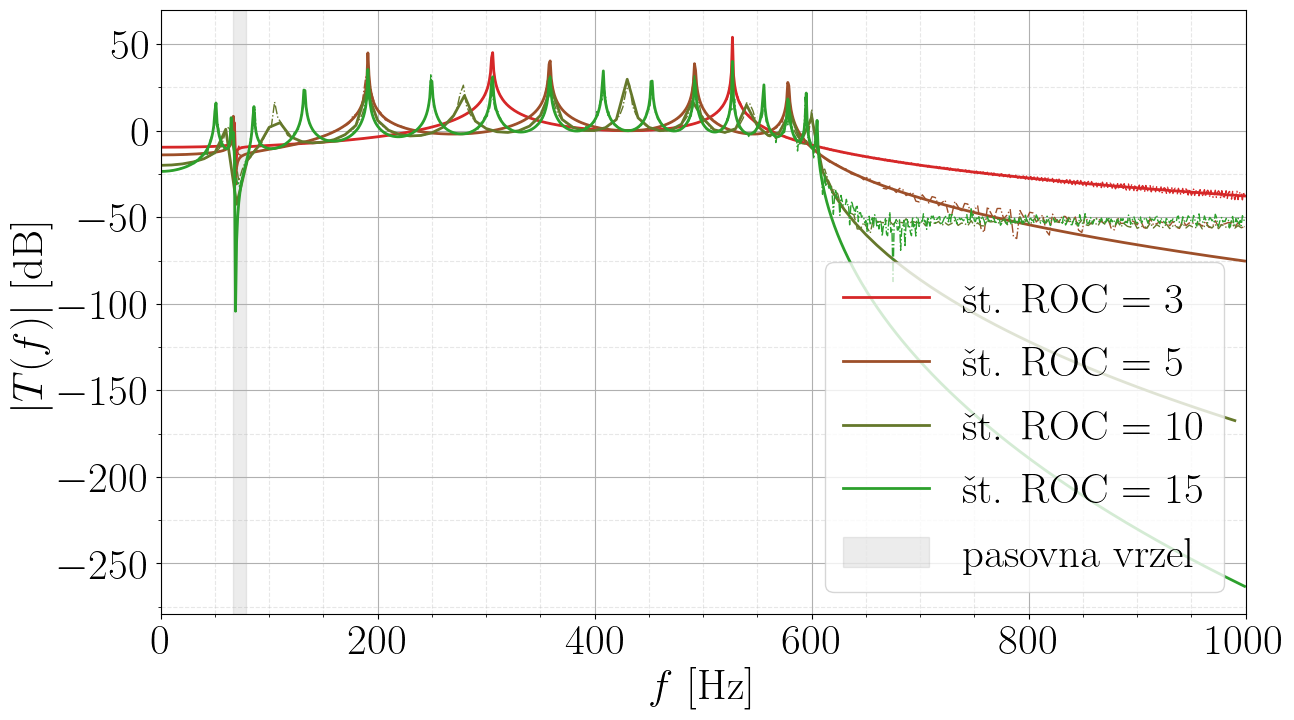

In [38]:
### Izris Abs(T)
plt.rcParams['figure.figsize'] = [14, 8]
c1 = "tab:red"
c2 = "tab:green"
m = 3

# Numerika Mathematica

#ROC3
plt.plot(ff_lin_3, 20 * np.log10(np.abs(ft_Re_lin_3 + ft_Im_lin_3*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 0/m), label=r'št. ROC $= 3$')
plt.plot(ff_3, 20 * np.log10(np.abs(ft_Re_3 + ft_Im_3*1j)), 
         linestyle="-.", lw=1, color=colorFader(c1,c2, 0/m))

#ROC5
plt.plot(ff_lin_5, 20 * np.log10(np.abs(ft_Re_lin_5 + ft_Im_lin_5*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 1/m), label=r'št. ROC $= 5$')
plt.plot(ff_5, 20 * np.log10(np.abs(ft_Re_5 + ft_Im_5*1j)), 
         linestyle="-.", lw=1, color=colorFader(c1,c2, 1/m))

#ROC10
plt.plot(ff_lin_10, 20 * np.log10(np.abs(ft_Re_lin_10 + ft_Im_lin_10*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 2/m), label=r'št. ROC $= 10$')
plt.plot(ff_10, 20 * np.log10(np.abs(ft_Re_10 + ft_Im_10*1j)), 
         linestyle="-.", lw=1, color=colorFader(c1,c2, 2/m))

#ROC15
plt.plot(ff_lin_15, 20 * np.log10(np.abs(ft_Re_lin_15 + ft_Im_lin_15*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 3/m), label=r'št. ROC $= 15$')
plt.plot(ff_15, 20 * np.log10(np.abs(ft_Re_15 + ft_Im_15*1j)), 
         linestyle="-.", lw=1, color=colorFader(c1,c2, 3/m))

plt.axvspan(67, 79, alpha=0.15, color='grey', label='pasovna vrzel')


plt.xlabel(r'$f $ [Hz]')
plt.ylabel(r'$|T(f)|$ [dB]')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=8)
plt.xlim(0, 1000)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.legend(loc='lower right')
plt.savefig('T_ROCn_1.pdf', format='pdf')
plt.show()

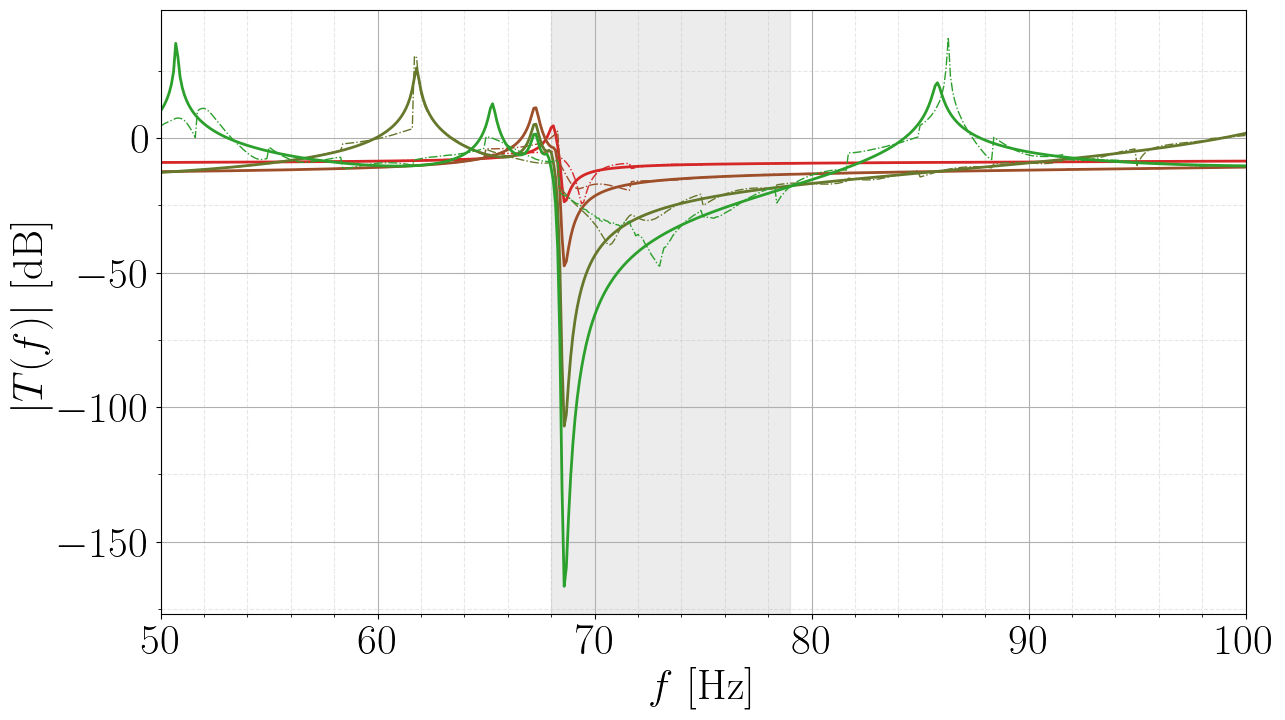

In [39]:
### Izris Abs(T) pobližano
# Numerika Mathematica

#ROC3
plt.plot(ffgap_lin_3, 20 * np.log10(np.abs(ftgap_Re_lin_3 + ftgap_Im_lin_3*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 0/m))
plt.plot(ffgap_3, 20 * np.log10(np.abs(ftgap_Re_3 + ftgap_Im_3*1j)), 
         linestyle="-.", lw=1, color=colorFader(c1,c2, 0/m))

#ROC5
plt.plot(ffgap_lin_5, 20 * np.log10(np.abs(ftgap_Re_lin_5 + ftgap_Im_lin_5*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 1/m))
plt.plot(ffgap_5, 20 * np.log10(np.abs(ftgap_Re_5 + ftgap_Im_5*1j)), 
         linestyle="-.", lw=1, color=colorFader(c1,c2, 1/m))

#ROC10
plt.plot(ffgap_lin_10, 20 * np.log10(np.abs(ftgap_Re_lin_10 + ftgap_Im_lin_10*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 2/m))
plt.plot(ffgap_10, 20 * np.log10(np.abs(ftgap_Re_10 + ftgap_Im_10*1j)), 
         linestyle="-.", lw=1, color=colorFader(c1,c2, 2/m))

#ROC15
plt.plot(ffgap_lin_15, 20 * np.log10(np.abs(ftgap_Re_lin_15 + ftgap_Im_lin_15*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 3/m))
plt.plot(ffgap_15, 20 * np.log10(np.abs(ftgap_Re_15 + ftgap_Im_15*1j)), 
         linestyle="-.", lw=1, color=colorFader(c1,c2, 3/m))


plt.axvspan(68, 79, alpha=0.15, color='grey')


plt.xlabel(r'$f $ [Hz]')
plt.ylabel(r'$|T(f)|$ [dB]')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=8)
plt.xlim(50, 100)
#plt.ylim(-50, 50)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.savefig('T_ROCn_2.pdf', format='pdf')
plt.show()

### FRF pri različem zaprtju MM za ROC=3 ###

In [154]:
### import Mathematica ###

# 0 mm
# numerični model
ff_1 = np.loadtxt("Mathematica/3ROC/FRF_MM_0mm/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_1 = np.loadtxt("Mathematica/3ROC/FRF_MM_0mm/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_1 = np.loadtxt("Mathematica/3ROC/FRF_MM_0mm/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_1 = np.loadtxt("Mathematica/3ROC/FRF_MM_0mm/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_1 = np.loadtxt("Mathematica/3ROC/FRF_MM_0mm/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_1 = np.loadtxt("Mathematica/3ROC/FRF_MM_0mm/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)
# numerični model (zoom)
ffgap_1 = np.loadtxt("Mathematica/3ROC/FRF_MM_0mm/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_1 = np.loadtxt("Mathematica/3ROC/FRF_MM_0mm/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_1 = np.loadtxt("Mathematica/3ROC/FRF_MM_0mm/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran (zoom)
ffgap_lin_1 = np.loadtxt("Mathematica/3ROC/FRF_MM_0mm/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_lin_1 = np.loadtxt("Mathematica/3ROC/FRF_MM_0mm/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_lin_1 = np.loadtxt("Mathematica/3ROC/FRF_MM_0mm/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2,7 mm
# numerični model
ff_2 = np.loadtxt("Mathematica/3ROC/FRF_MM_2,7mm/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_2 = np.loadtxt("Mathematica/3ROC/FRF_MM_2,7mm/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_2 = np.loadtxt("Mathematica/3ROC/FRF_MM_2,7mm/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_2 = np.loadtxt("Mathematica/3ROC/FRF_MM_2,7mm/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_2 = np.loadtxt("Mathematica/3ROC/FRF_MM_2,7mm/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_2 = np.loadtxt("Mathematica/3ROC/FRF_MM_2,7mm/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)
# numerični model (zoom)
ffgap_2 = np.loadtxt("Mathematica/3ROC/FRF_MM_2,7mm/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_2 = np.loadtxt("Mathematica/3ROC/FRF_MM_2,7mm/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_2 = np.loadtxt("Mathematica/3ROC/FRF_MM_2,7mm/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran (zoom)
ffgap_lin_2 = np.loadtxt("Mathematica/3ROC/FRF_MM_2,7mm/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_lin_2 = np.loadtxt("Mathematica/3ROC/FRF_MM_2,7mm/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_lin_2 = np.loadtxt("Mathematica/3ROC/FRF_MM_2,7mm/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 3,9 mm
# numerični model
ff_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_3,9mm/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_3,9mm/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_3,9mm/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_3,9mm/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_3,9mm/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_3,9mm/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)
# numerični model (zoom)
ffgap_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_3,9mm/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_3,9mm/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_3,9mm/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran (zoom)
ffgap_lin_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_3,9mm/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_lin_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_3,9mm/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_lin_3 = np.loadtxt("Mathematica/3ROC/FRF_MM_3,9mm/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 4,9 mm
# numerični model
ff_4 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_4 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_4 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_4 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_4 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_4 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)
# numerični model (zoom)
ffgap_4 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ffgap.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_4 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ftgap_Re.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_4 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ftgap_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran (zoom)
ffgap_lin_4 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ffgap_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Re_lin_4 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ftgap_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ftgap_Im_lin_4 = np.loadtxt("Mathematica/3ROC/FRF_MM_4,9mm/ftgap_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

In [158]:
## Parametri
Ep = 2400 #MPa
En = 2400 #MPa
t1 = 0.5 #mm
t2 = 0.25 #mm
h = 10*t2 #mm
b = 4 #mm
I1 = b*t1**3 / 12 #mm^4
I2 = b*t2**3 / 12 #mm^4
l1 = 13 #mm
l2 = 20.37 #mm


# Analitične vrednosti togosti posameznih območij (Mathematica)
kp = 20.372*Ep*I1/l1**3
kn1 = 9250*En*I2/l2**3
kn2 = -1253.18*En*I2/l2**3
kn3 = 10571.42*En*I2/l2**3

# celotne togosti in pomiki ROC
k1 = kp+1/2*kn1
k2 = kp+1/2*kn2
k3 = kp+1/2*kn3
dzg = 2*0.16*h
dsr = 2*1.33*h
dsp = 2*1.92*h
dk = 2*1.99*h
# skupne sile
F1 = k1*(dzg-0)
F2 = F1 + k2*(dsp-dzg)
F3 = F2 + k3*(dk-dsp)
# pozitivne sile
Fp = kp*dk
# negativne sile
Fzg = 1/2*kn1*(dzg-0)
Fsp = Fzg + 1/2*kn2*(dsp-dzg)
    
d = np.array([dzg, dsr, dsp, dk])
F = np.array([F1, F2, F3])

# Zvezna sila z Taylorjevo vrsto
n0 = 5.58
a1 = 1/(2*(1-gamma)*gamma**2)
a2 = -3/(8*(1-gamma)*gamma**4)
a3 = 0.08
b1 = 220
b2 = 0.04
##
upsilon = a3
mu = 2
gamma = mu/(mu+2)
##

xp = np.linspace(-5, dk, 50)
Fapr = lambda x : n0 + a3*x + b1*(a1*(b2*(x-dk/2))**3 + a2*(b2*(x-dk/2))**5)
kapr = lambda x : 0.08 + 220 * (0.000768 * (-4.975 + x)**2 - 6.144*10**(-6) * (-4.975 + x)**4)

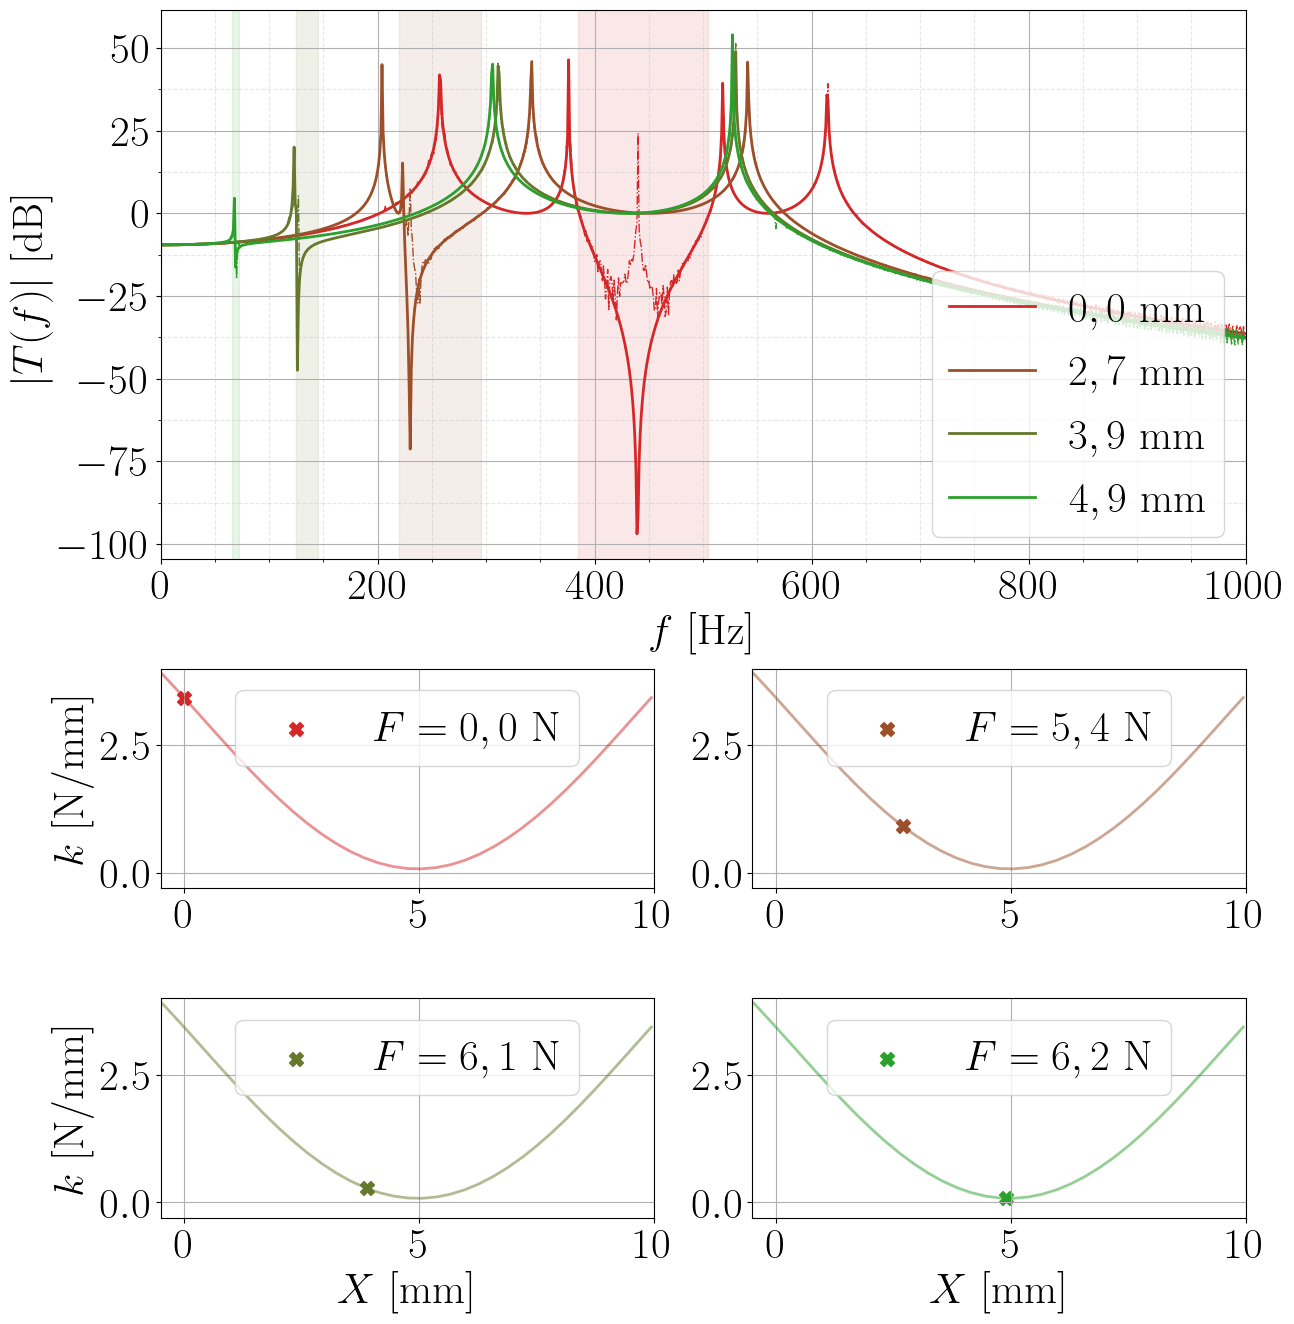

In [174]:
# Izris
plt.rcParams['figure.figsize'] = [14, 8]
c1 = "tab:red"
c2 = "tab:green"
m = 3

# Setup figure and subplots
fig = plt.figure(num = 0, figsize = (14, 16))#, dpi = 300)
ax1 = plt.subplot2grid((4, 2), (2, 0))
ax2 = plt.subplot2grid((4, 2), (2, 1))
ax3 = plt.subplot2grid((4, 2), (3, 0))
ax4 = plt.subplot2grid((4, 2), (3, 1))
ax0 = plt.subplot2grid((4, 2), (0, 0), colspan=2, rowspan=2)
axs=[ax0,ax1,ax2,ax3,ax4]

plt.subplots_adjust(wspace=0.2, hspace=0.5)

# PRENOSNOST
#0mm
axs[0].plot(ff_lin_1, 20 * np.log10(np.abs(ft_Re_lin_1 + ft_Im_lin_1*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 0/m), label=r'$0,0$ mm')
axs[0].plot(ff_1, 20 * np.log10(np.abs(ft_Re_1 + ft_Im_1*1j)), 
         linestyle="-.", lw=1, color=colorFader(c1,c2, 0/m))
axs[0].axvspan(385, 505, alpha=0.10, color=colorFader(c1,c2, 0/m))

#2,7mm
axs[0].plot(ff_lin_2, 20 * np.log10(np.abs(ft_Re_lin_2 + ft_Im_lin_2*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 1/m), label=r'$2,7$ mm')
axs[0].plot(ff_2, 20 * np.log10(np.abs(ft_Re_2 + ft_Im_2*1j)), 
         linestyle="-.", lw=1, color=colorFader(c1,c2, 1/m))
axs[0].axvspan(220, 295, alpha=0.10, color=colorFader(c1,c2, 1/m))

#3,9mm
axs[0].plot(ff_lin_3, 20 * np.log10(np.abs(ft_Re_lin_3 + ft_Im_lin_3*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 2/m), label=r'$3,9$ mm')
axs[0].plot(ff_3, 20 * np.log10(np.abs(ft_Re_3 + ft_Im_3*1j)), 
         linestyle="-.", lw=1, color=colorFader(c1,c2, 2/m))
axs[0].axvspan(125, 145, alpha=0.10, color=colorFader(c1,c2, 2/m))

#4,9mm
axs[0].plot(ff_lin_4, 20 * np.log10(np.abs(ft_Re_lin_4 + ft_Im_lin_4*1j)), 
         linestyle="-", lw=2, color=colorFader(c1,c2, 3/m), label=r'$4,9$ mm')
axs[0].plot(ff_4, 20 * np.log10(np.abs(ft_Re_4 + ft_Im_4*1j)), 
         linestyle="-.", lw=1, color=colorFader(c1,c2, 3/m))
axs[0].axvspan(66, 72, alpha=0.10, color=colorFader(c1,c2, 3/m))

axs[0].set_xlabel(r'$f $ [Hz]')
axs[0].set_ylabel(r'$|T(f)|$ [dB]')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=8)
axs[0].set_xlim(0, 1000)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
axs[0].grid()
axs[0].grid(which='minor', linestyle = '--', alpha=0.3)
axs[0].legend(loc='lower right')


# TOČKA in TAYLOR
xt=0.0
axs[1].scatter(x=xt, y=kapr(xt), c=colorFader(c1,c2, 0/m), marker='X', s=100, label=r'$F=0,0$ N')
axs[1].plot(xp, kapr(xp), linestyle="-", lw=2, alpha=0.5, color=colorFader(c1,c2, 0/m))
xt=2.7
axs[2].scatter(x=xt, y=kapr(xt), c=colorFader(c1,c2, 1/m), marker='X', s=100, label=r'$F = 5,4$ N')
axs[2].plot(xp, kapr(xp), linestyle="-", lw=2, alpha=0.5, color=colorFader(c1,c2, 1/m))
xt=3.9
axs[3].scatter(x=xt, y=kapr(xt), c=colorFader(c1,c2, 2/m), marker='X', s=100, label=r'$F = 6,1$ N')
axs[3].plot(xp, kapr(xp), linestyle="-", lw=2, alpha=0.5, color=colorFader(c1,c2, 2/m))
xt=4.9
axs[4].scatter(x=xt, y=kapr(xt), c=colorFader(c1,c2, 3/m), marker='X', s=100, label=r'$F = 6,2$ N')
axs[4].plot(xp, kapr(xp), linestyle="-", lw=2, alpha=0.5, color=colorFader(c1,c2, 3/m))

axs[3].set_xlabel(r'$X$ [mm]')
axs[4].set_xlabel(r'$X$ [mm]')
axs[1].set_ylabel(r'$k$ [N/mm]')
axs[3].set_ylabel(r'$k$ [N/mm]')

axs[1].set_xlim(-0.5, 10)
axs[2].set_xlim(-0.5, 10)
axs[3].set_xlim(-0.5, 10)
axs[4].set_xlim(-0.5, 10)
axs[1].set_ylim(-0.3, 4)
axs[2].set_ylim(-0.3, 4)
axs[3].set_ylim(-0.3, 4)
axs[4].set_ylim(-0.3, 4)
axs[1].grid()
axs[2].grid()
axs[3].grid()
axs[4].grid()
axs[1].legend()
axs[2].legend()
axs[3].legend()
axs[4].legend()

plt.savefig('T_ROC_prednapetje.pdf', format='pdf')
plt.show()

### FRF pri različnih temperaturah MM za ROC=3  ###

In [212]:
### import Mathematica ###
#[2400, 2378, 2355, 2318, 2280, 2240, 2200, 2140, 2080]

# 2400 MPa
# numerični model
ff_1 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2400/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_1 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2400/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_1 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2400/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_1 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2400/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_1 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2400/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_1 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2400/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2378 MPa
# numerični model
ff_2 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2378/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_2 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2378/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_2 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2378/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_2 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2378/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_2 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2378/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_2 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2378/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2355 MPa
# numerični model
ff_3 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2355/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_3 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2355/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_3 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2355/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_3 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2355/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_3 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2355/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_3 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2355/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2318 MPa
# numerični model
ff_4 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2318/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_4 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2318/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_4 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2318/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_4 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2318/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_4 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2318/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_4 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2318/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2280 MPa
# numerični model
ff_5 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2280/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_5 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2280/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_5 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2280/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_5 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2280/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_5 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2280/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_5 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2280/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2240 MPa
# numerični model
ff_6 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2240/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_6 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2240/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_6 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2240/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_6 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2240/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_6 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2240/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_6 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2240/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2200 MPa
# numerični model
ff_7 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2200/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_7 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2200/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_7 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2200/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_7 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2200/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_7 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2200/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_7 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2200/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2140 MPa
# numerični model
ff_8 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2140/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_8 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2140/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_8 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2140/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_8 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2140/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_8 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2140/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_8 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2140/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

# 2140 MPa
# numerični model
ff_9 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2080/ff.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_9 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2080/ft_Re.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_9 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2080/ft_Im.txt", dtype=float, usecols=0, skiprows=0)
# numerični model lineariziran
ff_lin_9 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2080/ff_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Re_lin_9 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2080/ft_Re_lin.txt", dtype=float, usecols=0, skiprows=0)
ft_Im_lin_9 = np.loadtxt("Mathematica/3ROC_temp/FRF_MM_3ROC_En2080/ft_Im_lin.txt", dtype=float, usecols=0, skiprows=0)

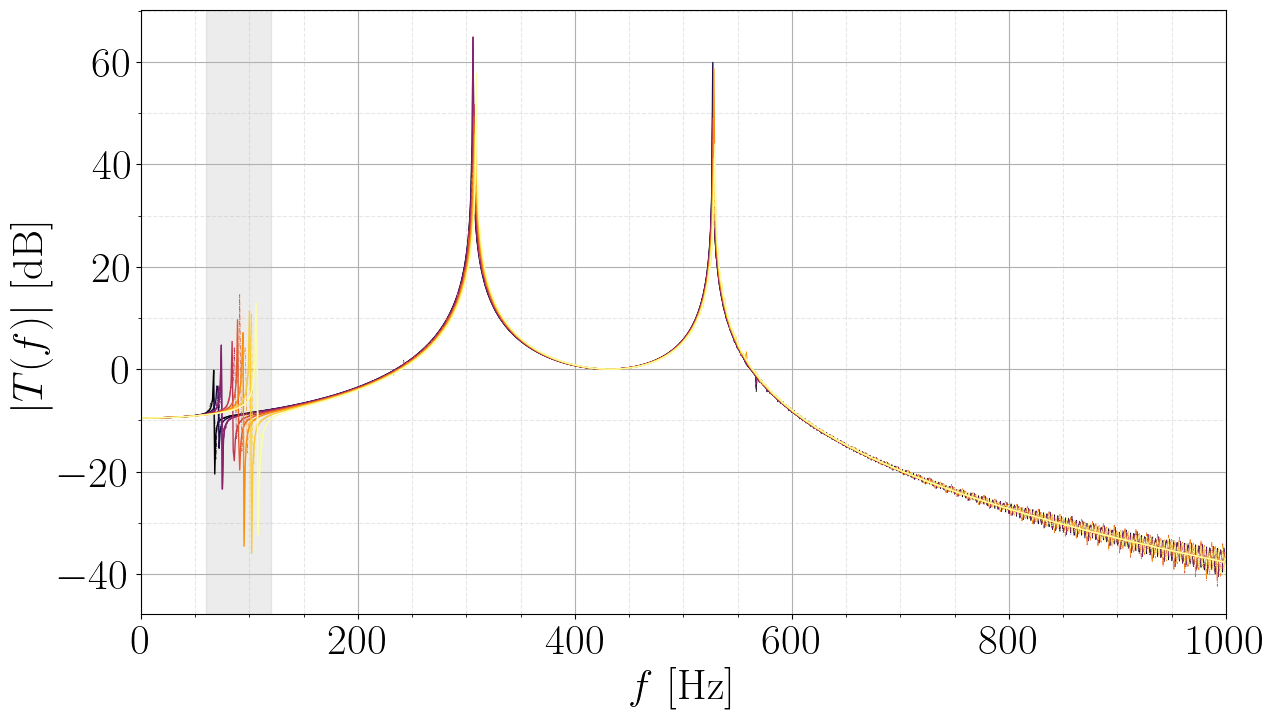

In [225]:
### Izris Abs(T)
plt.rcParams['figure.figsize'] = [14, 8]
# Color bar
T_values = [22.0, 23.5, 25.0, 27.5, 30.0, 32.5, 35.0, 37.5, 40.0]
N = len(T_values)
cmap = plt.get_cmap('inferno',N)
norm = mpl.colors.Normalize(vmin=T_values[0],vmax=T_values[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Numerika Mathematica

#En=2400MPa
plt.plot(ff_lin_1, 20 * np.log10(np.abs(ft_Re_lin_1 + ft_Im_lin_1*1j)), 
         linestyle="-", lw=1, color=cmap(0))
plt.plot(ff_1, 20 * np.log10(np.abs(ft_Re_1 + ft_Im_1*1j)), 
         linestyle="-.", lw=0.5, color=cmap(0))

#En=2378MPa
plt.plot(ff_lin_2, 20 * np.log10(np.abs(ft_Re_lin_2 + ft_Im_lin_2*1j)), 
         linestyle="-", lw=1, color=cmap(1))
plt.plot(ff_2, 20 * np.log10(np.abs(ft_Re_2 + ft_Im_2*1j)), 
         linestyle="-.", lw=0.5, color=cmap(1))

#En=2355MPa
plt.plot(ff_lin_3, 20 * np.log10(np.abs(ft_Re_lin_3 + ft_Im_lin_3*1j)), 
         linestyle="-", lw=1, color=cmap(2))
plt.plot(ff_3, 20 * np.log10(np.abs(ft_Re_3 + ft_Im_2*1j)), 
         linestyle="-.", lw=0.5, color=cmap(2))

#En=2318MPa
plt.plot(ff_lin_4, 20 * np.log10(np.abs(ft_Re_lin_3 + ft_Im_lin_3*1j)), 
         linestyle="-", lw=1, color=cmap(3))
plt.plot(ff_4, 20 * np.log10(np.abs(ft_Re_3 + ft_Im_2*1j)), 
         linestyle="-.", lw=0.5, color=cmap(3))

#En=2280MPa
plt.plot(ff_lin_5, 20 * np.log10(np.abs(ft_Re_lin_5 + ft_Im_lin_5*1j)), 
         linestyle="-", lw=1, color=cmap(4))
plt.plot(ff_5, 20 * np.log10(np.abs(ft_Re_5 + ft_Im_5*1j)), 
         linestyle="-.", lw=0.5, color=cmap(4))

#En=2240MPa
plt.plot(ff_lin_6, 20 * np.log10(np.abs(ft_Re_lin_6 + ft_Im_lin_6*1j)), 
         linestyle="-", lw=1, color=cmap(5))
plt.plot(ff_6, 20 * np.log10(np.abs(ft_Re_6 + ft_Im_6*1j)), 
         linestyle="-.", lw=0.5, color=cmap(5))

#En=2200MPa
plt.plot(ff_lin_7, 20 * np.log10(np.abs(ft_Re_lin_7 + ft_Im_lin_7*1j)), 
         linestyle="-", lw=1, color=cmap(6))
plt.plot(ff_7, 20 * np.log10(np.abs(ft_Re_7 + ft_Im_7*1j)), 
         linestyle="-.", lw=0.5, color=cmap(6))

#En=2140MPa
plt.plot(ff_lin_8, 20 * np.log10(np.abs(ft_Re_lin_8 + ft_Im_lin_8*1j)), 
         linestyle="-", lw=1, color=cmap(7))
plt.plot(ff_8, 20 * np.log10(np.abs(ft_Re_8 + ft_Im_8*1j)), 
         linestyle="-.", lw=0.5, color=cmap(7))

#En=2080MPa
plt.plot(ff_lin_9, 20 * np.log10(np.abs(ft_Re_lin_9 + ft_Im_lin_9*1j)), 
         linestyle="-", lw=1, color=cmap(8))
plt.plot(ff_9, 20 * np.log10(np.abs(ft_Re_9 + ft_Im_9*1j)), 
         linestyle="-.", lw=0.5, color=cmap(8))

# pasovna vrzel
plt.axvspan(60, 120, alpha=0.15, color='grey')

plt.xlabel(r'$f $ [Hz]')
plt.ylabel(r'$|T(f)|$ [dB]')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=8)
plt.xlim(0, 1000)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.savefig('T_ROC3_dT_1.pdf', format='pdf')
plt.show()

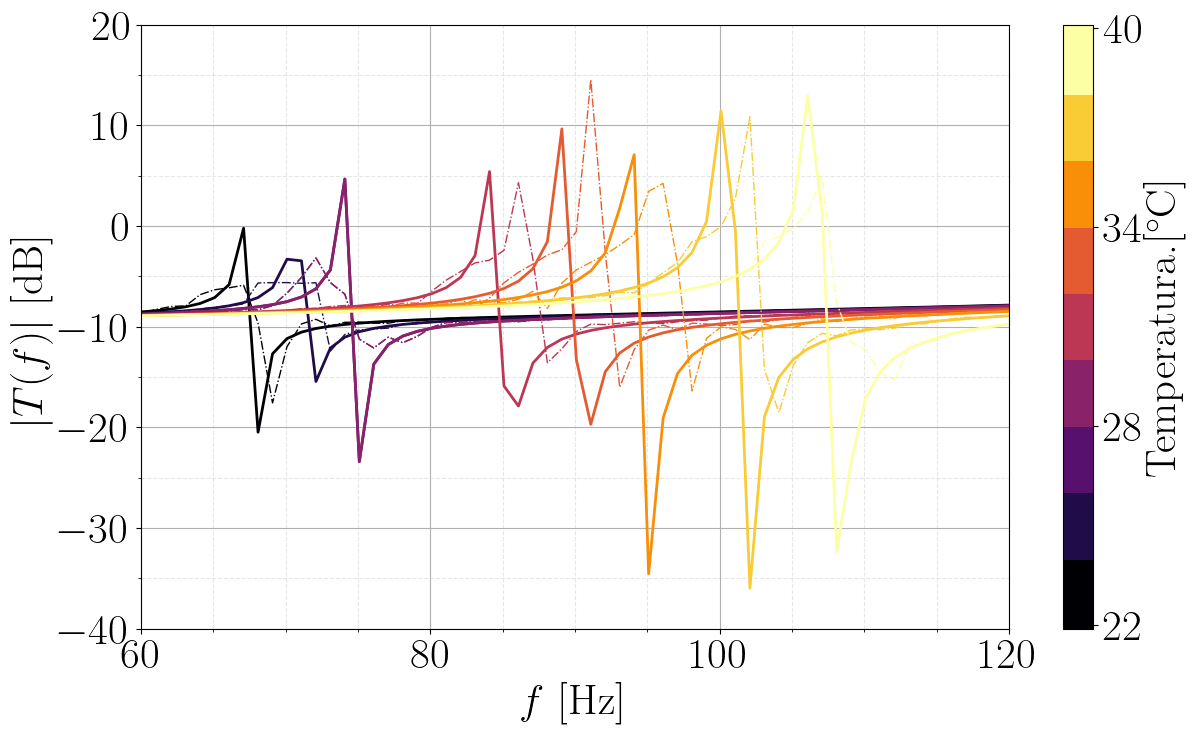

In [234]:
### Izris Abs(T)
plt.rcParams['figure.figsize'] = [14, 8]
# Color bar
T_values = [22.0, 23.5, 25.0, 27.5, 30.0, 32.5, 35.0, 37.5, 40.0]
N = len(T_values)
cmap = plt.get_cmap('inferno',N)
norm = mpl.colors.Normalize(vmin=T_values[0],vmax=T_values[-1])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Numerika Mathematica

#En=2400MPa
plt.plot(ff_lin_1, 20 * np.log10(np.abs(ft_Re_lin_1 + ft_Im_lin_1*1j)), 
         linestyle="-", lw=2, color=cmap(0))
plt.plot(ff_1, 20 * np.log10(np.abs(ft_Re_1 + ft_Im_1*1j)), 
         linestyle="-.", lw=1, color=cmap(0))

#En=2378MPa
plt.plot(ff_lin_2, 20 * np.log10(np.abs(ft_Re_lin_2 + ft_Im_lin_2*1j)), 
         linestyle="-", lw=2, color=cmap(1))
plt.plot(ff_2, 20 * np.log10(np.abs(ft_Re_2 + ft_Im_2*1j)), 
         linestyle="-.", lw=1, color=cmap(1))

#En=2355MPa
plt.plot(ff_lin_3, 20 * np.log10(np.abs(ft_Re_lin_3 + ft_Im_lin_3*1j)), 
         linestyle="-", lw=2, color=cmap(2))
plt.plot(ff_3, 20 * np.log10(np.abs(ft_Re_3 + ft_Im_2*1j)), 
         linestyle="-.", lw=1, color=cmap(2))

#En=2318MPa
plt.plot(ff_lin_4, 20 * np.log10(np.abs(ft_Re_lin_3 + ft_Im_lin_3*1j)), 
         linestyle="-", lw=2, color=cmap(3))
plt.plot(ff_4, 20 * np.log10(np.abs(ft_Re_3 + ft_Im_2*1j)), 
         linestyle="-.", lw=1, color=cmap(3))

#En=2280MPa
plt.plot(ff_lin_5, 20 * np.log10(np.abs(ft_Re_lin_5 + ft_Im_lin_5*1j)), 
         linestyle="-", lw=2, color=cmap(4))
plt.plot(ff_5, 20 * np.log10(np.abs(ft_Re_5 + ft_Im_5*1j)), 
         linestyle="-.", lw=1, color=cmap(4))

#En=2240MPa
plt.plot(ff_lin_6, 20 * np.log10(np.abs(ft_Re_lin_6 + ft_Im_lin_6*1j)), 
         linestyle="-", lw=2, color=cmap(5))
plt.plot(ff_6, 20 * np.log10(np.abs(ft_Re_6 + ft_Im_6*1j)), 
         linestyle="-.", lw=1, color=cmap(5))

#En=2200MPa
plt.plot(ff_lin_7, 20 * np.log10(np.abs(ft_Re_lin_7 + ft_Im_lin_7*1j)), 
         linestyle="-", lw=2, color=cmap(6))
plt.plot(ff_7, 20 * np.log10(np.abs(ft_Re_7 + ft_Im_7*1j)), 
         linestyle="-.", lw=1, color=cmap(6))

#En=2140MPa
plt.plot(ff_lin_8, 20 * np.log10(np.abs(ft_Re_lin_8 + ft_Im_lin_8*1j)), 
         linestyle="-", lw=2, color=cmap(7))
plt.plot(ff_8, 20 * np.log10(np.abs(ft_Re_8 + ft_Im_8*1j)), 
         linestyle="-.", lw=1, color=cmap(7))

#En=2080MPa
plt.plot(ff_lin_9, 20 * np.log10(np.abs(ft_Re_lin_9 + ft_Im_lin_9*1j)), 
         linestyle="-", lw=2, color=cmap(8))
plt.plot(ff_9, 20 * np.log10(np.abs(ft_Re_9 + ft_Im_9*1j)), 
         linestyle="-.", lw=1, color=cmap(8))

plt.xlabel(r'$f $ [Hz]')
plt.ylabel(r'$|T(f)|$ [dB]')
plt.locator_params(axis="x", nbins=5)
plt.locator_params(axis="y", nbins=8)
plt.xlim(60, 120)
plt.ylim(-40, 20)
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(2))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.grid()
plt.grid(which='minor', linestyle = '--', alpha=0.3)
plt.colorbar(sm, ticks=np.linspace(22,T_values[-1],int(N/2)), 
             boundaries=np.arange(T_values[0]-0.1,T_values[-1]+0.1,.01)
            ).set_label(r'Temperatura.$[^\circ$C]', labelpad=0.5, y=0.5, rotation=90)
plt.savefig('T_ROC3_dT_2.pdf', format='pdf')
plt.show()

## FRF $H(\omega)=F/$g ##

### MM dinamika 1 ROC ###

In [351]:
# Esperiment
data_1 = MeritevDinamike('Analiza/1ROC/MM_T21_roc1_0N_set1.lvm')
data_2 = MeritevDinamike('Analiza/1ROC/MM_T21_roc1_8N_set2.lvm')
data_3 = MeritevDinamike('Analiza/1ROC/MM_T21_roc1_16N_set1.lvm')
data_4 = MeritevDinamike('Analiza/1ROC/MM_T21_roc1_20N_set1.lvm')
#data_5 = MeritevDinamike('Analiza/1ROC/MM_T21_roc1_24N_set1.lvm')
#data_6 = MeritevDinamike('Analiza/1ROC/MM_T21_roc1_32N_set1.lvm')

# Sila iz Ansysa
ansys_filename = [
    "MKE/ROC1/FRF_MM_0mm.txt",
    "MKE/ROC1/FRF_MM_5mm.txt",
    "MKE/ROC1/FRF_MM_9mm.txt",
    "MKE/ROC1/FRF_MM_11mm.txt",
    #"MKE/ROC1/FRF_MM_12mm.txt",
    #"MKE/ROC1/FRF_MM_13mm.txt",
    #"MKE/ROC1/FRF_MM_14mm.txt",
    #"MKE/ROC1/FRF_MM_15mm.txt"
]

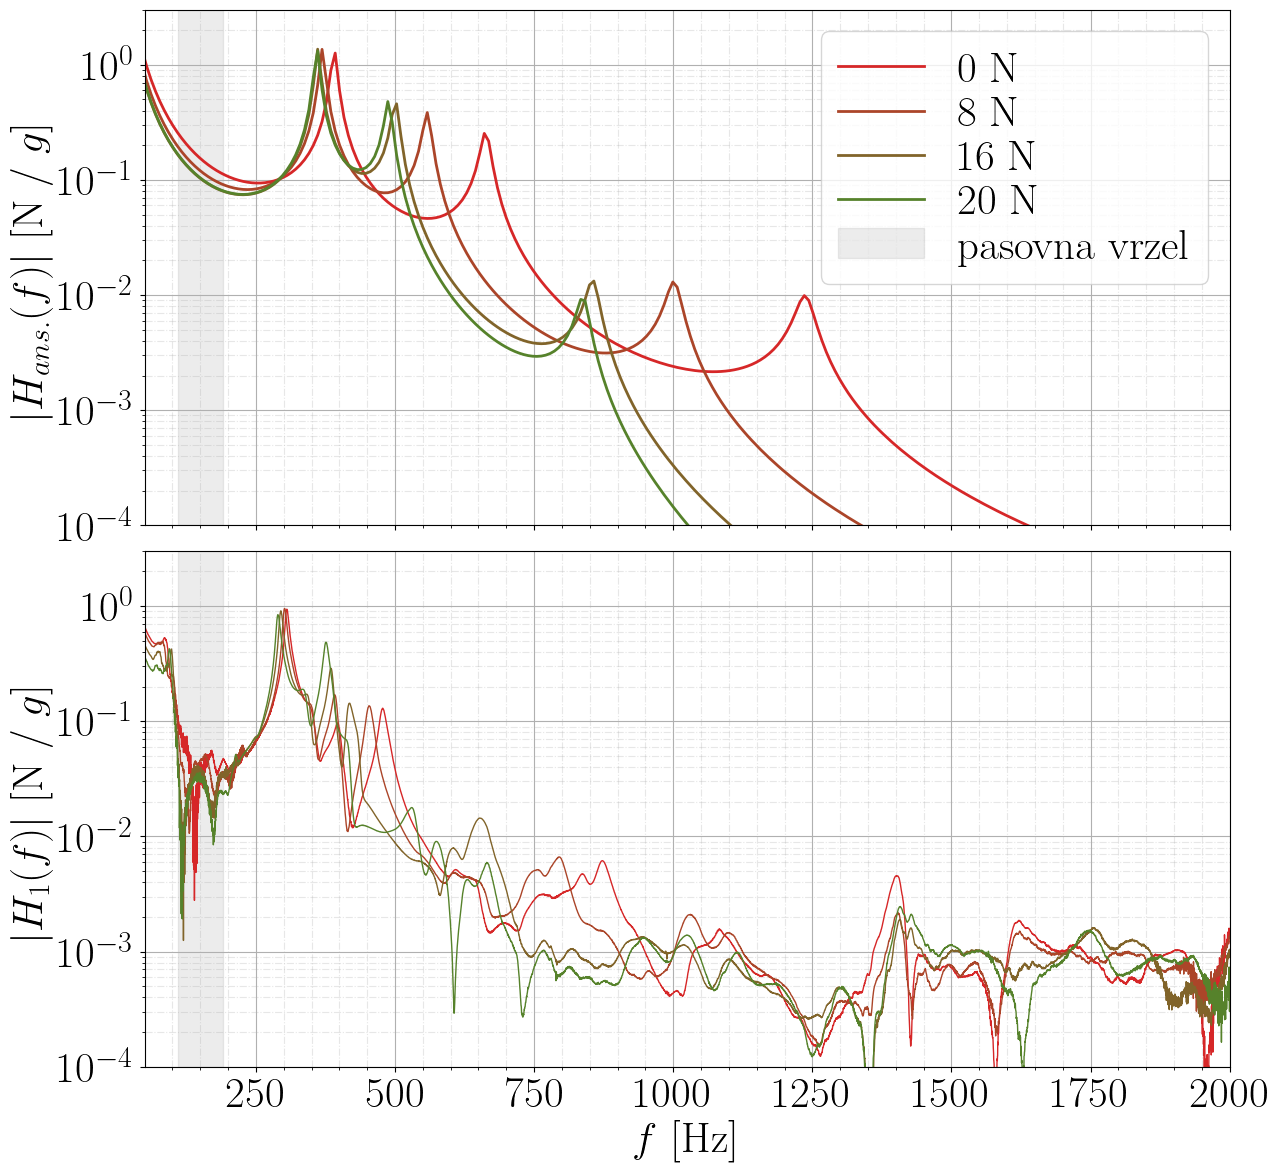

In [345]:
plt.rcParams['figure.figsize'] = [14, 14]
fig, axs = plt.subplots(2, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.05)

# Podatki
data_group = [data_1, data_2, data_3, data_4]
predNap = [0,8,16,20]
i = 0

c1 = "tab:red"
c2 = "tab:green"

for data_j in data_group:
    
     # ANSYS
        
    xf_ansys = np.loadtxt(ansys_filename[i], dtype=float, usecols=1, skiprows=1)
    xf_ansys = np.insert(xf_ansys, 0, 0)
    yf_ansys_real = np.loadtxt(ansys_filename[i], dtype=float, usecols=2, skiprows=1)
    yf_ansys_imag = np.loadtxt(ansys_filename[i], dtype=float, usecols=3, skiprows=1)
    yf_ansys = np.sqrt(yf_ansys_real**2 + yf_ansys_imag**2)
    
    axs[0].semilogy(xf_ansys[1:], yf_ansys, linestyle='-', lw=2, color=colorFader(c1,c2, i/len(data_group)), label=f'{predNap[i]} N')
    
    # EKSPERIMENT
    
    dt = data_j.time()[0] 
    fs = data_j.time()[1]
    time = data_j.time()[2]
            
    t_start = time[-1]/10 #s
    t_step = time[-1]/1.1 #s
    
    g_input = data_j.instruments()[0]
    F_output = data_j.instruments()[1]
     
    t_1 = int(t_start*len(time)/time[-1])
    t_2 = int((t_start+t_step)*len(time)/time[-1])
    
    # fft
    #yfl = np.fft.rfft(F_output[t_1:t_2:])
    #yfp = np.fft.rfft(g_input[t_1:t_2:])
    #yf = yfl/yfp
    #xf = np.fft.rfftfreq(len(F_output[t_1:t_2:]), dt)
    #axs[1].semilogy(xf, np.abs(yf), linewidth=0.1, linestyle='--', alpha=0.1, label=f'MM {i+1}', color=colorFader(c1,c2, i/len(data_group)))
    
    # fft with window
    # n = int(2**21) # sample size
    # m = len(F_output[t_1:t_2:])
    # yfl = np.fft.rfft(F_output[t_1:t_2:] * get_window('hann', Nx = m), n=n)
    # yfp = np.fft.rfft(g_input[t_1:t_2:] * get_window('hann', Nx = m), n=n)
    # yf = yfl/yfp
    # xf = np.fft.rfftfreq(n, dt)
    # plt.semilogy(xf, np.abs(yf), linewidth=0.5, linestyle='-', alpha=0.3, label=f'MM {i+1}', color=color_group[i])
    # yf= np.abs(yf)
    # plt.semilogy(xf, smooth(yf, 10**1), linewidth=1, linestyle='-', alpha=1, label=f'MM {i+1}', color=color_group[i]) # smoothing
    
    # CSD
    xf, Pxy = signal.csd(g_input[t_1:t_2:], F_output[t_1:t_2:], fs, nperseg=fs*4)
    xf, Pxx = signal.csd(g_input[t_1:t_2:], g_input[t_1:t_2:], fs, nperseg=fs*4)
    H1 = Pxy / Pxx
    axs[1].semilogy(xf, np.abs(H1), linewidth=1, linestyle='-', alpha=1, label=f'MM {i+1}', color=colorFader(c1,c2, i/len(data_group)))
    
    i+=1
    

axs[0].axvspan(110, 190, alpha=0.15, color='grey', label='pasovna vrzel')
axs[1].axvspan(110, 190, alpha=0.15, color='grey', label='pasovna vrzel')
    
plt.xlim(50, 2000)
plt.ylim(10**(-4), 3)
plt.xlabel(r'$f$ [Hz]')
axs[0].set_ylabel(r'$|H_{ans.}(f)|$ [N / $g$]')
axs[1].set_ylabel(r'$|H_1(f)|$ [N / $g$]')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.rcParams.update({'legend.labelspacing':0.05})
axs[0].grid()
axs[1].grid()
axs[0].grid(which='minor', linestyle = '-.', alpha=0.3)
axs[1].grid(which='minor', linestyle = '-.', alpha=0.3)
axs[0].legend()
#plt.xticks(x_ticks)
plt.savefig('FRF_ROC1.pdf', format='pdf')
plt.show();

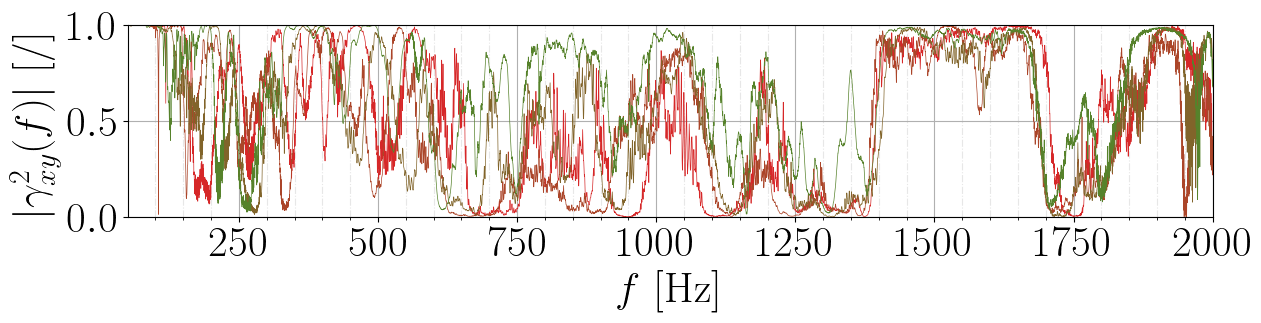

In [359]:
# Koherenca
plt.rcParams['figure.figsize'] = [14, 4]
plt.gcf().subplots_adjust(bottom=0.4)

i = 0

for data_j in data_group:
    
    dt = data_j.time()[0] 
    fs = data_j.time()[1]
    time = data_j.time()[2]
            
    t_start = time[-1]/10 #s
    t_step = time[-1]/1.1 #s
    
    g_input = data_j.instruments()[0]
    F_output = data_j.instruments()[1]

    # CSD
    xf, Pxy = signal.csd(g_input[t_1:t_2:], F_output[t_1:t_2:], fs, nperseg=fs*4)
    xf, Pxx = signal.csd(g_input[t_1:t_2:], g_input[t_1:t_2:], fs, nperseg=fs*4)
    xf, Pyy = signal.csd(F_output[t_1:t_2:], F_output[t_1:t_2:], fs, nperseg=fs*4)
    H1 = Pxy / Pxx
    H2 = Pyy / Pxy
    coh = H1/H2
    plt.plot(xf, np.abs(coh), linewidth=0.5, linestyle='-', alpha=1, label=f'MM {i+1}', color=colorFader(c1,c2, i/len(data_group)))
    
    i+=1
    
plt.xlim(50, 2000)
plt.ylim(0,1)
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$|\gamma^2_{xy}(f)|$ [/]')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
#plt.rcParams.update({'legend.labelspacing':0.05})
#plt.legend(ncol=1, prop={'size': 31})
plt.grid()
plt.grid(which='minor', linestyle = '-.', alpha=0.3)
#x_ticks = np.arange(50, 2000, 500)
#plt.xticks(x_ticks)
plt.savefig('koherenca_ROC1.pdf', format='pdf')
plt.show();

### MM dinamika 3 ROC ###

In [360]:
# Esperiment
data_1 = MeritevDinamike('Analiza/3ROC/MM_T21_roc3_0N_set3.lvm')
#data_2 = MeritevDinamike('Analiza/3ROC/MM_T21_roc3_4N_set1.lvm')
data_3 = MeritevDinamike('Analiza/3ROC/MM_T21_roc3_8N_set1.lvm')
#data_4 = MeritevDinamike('Analiza/3ROC/MM_T21_roc3_12N_set1.lvm')
data_5 = MeritevDinamike('Analiza/3ROC/MM_T21_roc3_16N_set1.lvm')
data_6 = MeritevDinamike('Analiza/3ROC/MM_T21_roc3_20N_set1.lvm')
#data_7 = MeritevDinamike('Analiza/3ROC/MM_T21_roc3_24N_set1.lvm')

# Sila iz Ansysa
ansys_filename = [
    "MKE/ROC3/FRF_MM_0mm.txt",
    "MKE/ROC3/FRF_MM_12,5mm.txt",
    "MKE/ROC3/FRF_MM_22,6mm.txt",
    "MKE/ROC3/FRF_MM_27,6mm.txt",
    #"MKE/ROC3/FRF_MM_30mm.txt",
]

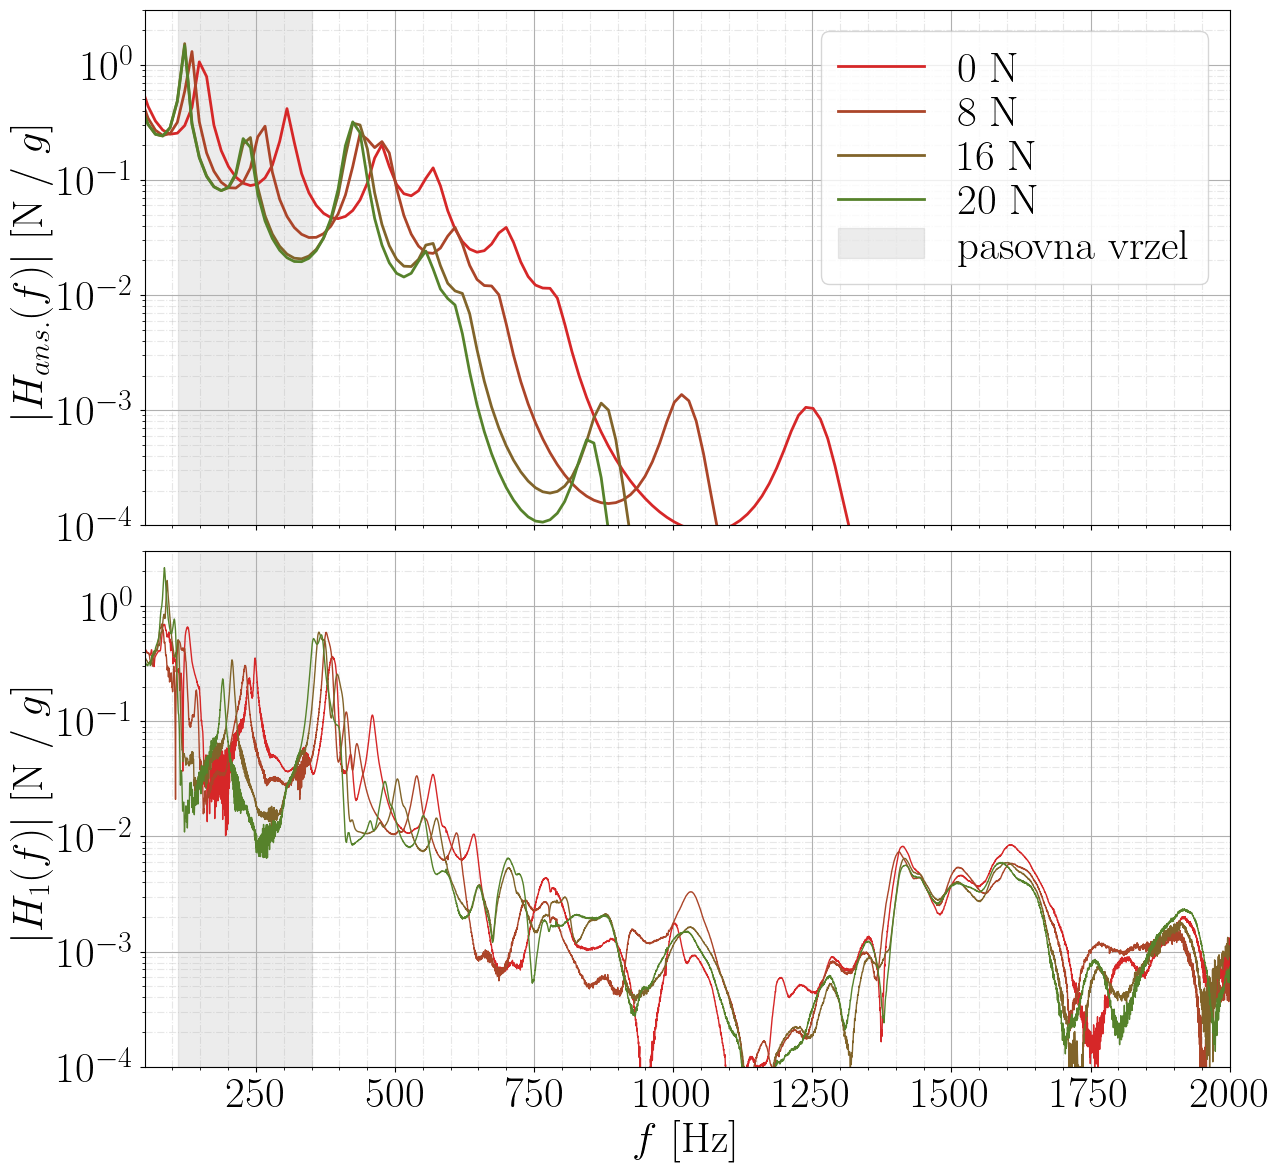

In [350]:
plt.rcParams['figure.figsize'] = [14, 14]
fig, axs = plt.subplots(2, sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.05)

# Podatki
data_group = [data_1, data_3, data_5, data_6]
predNap = [0,8,16,20]
i = 0

c1 = "tab:red"
c2 = "tab:green"

for data_j in data_group:
    
     # ANSYS
        
    xf_ansys = np.loadtxt(ansys_filename[i], dtype=float, usecols=1, skiprows=1)
    xf_ansys = np.insert(xf_ansys, 0, 0)
    yf_ansys_real = np.loadtxt(ansys_filename[i], dtype=float, usecols=2, skiprows=1)
    yf_ansys_imag = np.loadtxt(ansys_filename[i], dtype=float, usecols=3, skiprows=1)
    yf_ansys = np.sqrt(yf_ansys_real**2 + yf_ansys_imag**2)
    
    axs[0].semilogy(xf_ansys[1:], yf_ansys, linestyle='-', lw=2, color=colorFader(c1,c2, i/len(data_group)), label=f'{predNap[i]} N')
    
    # EKSPERIMENT
    
    dt = data_j.time()[0] 
    fs = data_j.time()[1]
    time = data_j.time()[2]
            
    t_start = time[-1]/10 #s
    t_step = time[-1]/1.1 #s
    
    g_input = data_j.instruments()[0]
    F_output = data_j.instruments()[1]
     
    t_1 = int(t_start*len(time)/time[-1])
    t_2 = int((t_start+t_step)*len(time)/time[-1])
    
    # fft
    #yfl = np.fft.rfft(F_output[t_1:t_2:])
    #yfp = np.fft.rfft(g_input[t_1:t_2:])
    #yf = yfl/yfp
    #xf = np.fft.rfftfreq(len(F_output[t_1:t_2:]), dt)
    #axs[1].semilogy(xf, np.abs(yf), linewidth=0.1, linestyle='--', alpha=0.1, label=f'MM {i+1}', color=colorFader(c1,c2, i/len(data_group)))
    
    # fft with window
    # n = int(2**21) # sample size
    # m = len(F_output[t_1:t_2:])
    # yfl = np.fft.rfft(F_output[t_1:t_2:] * get_window('hann', Nx = m), n=n)
    # yfp = np.fft.rfft(g_input[t_1:t_2:] * get_window('hann', Nx = m), n=n)
    # yf = yfl/yfp
    # xf = np.fft.rfftfreq(n, dt)
    # plt.semilogy(xf, np.abs(yf), linewidth=0.5, linestyle='-', alpha=0.3, label=f'MM {i+1}', color=color_group[i])
    # yf= np.abs(yf)
    # plt.semilogy(xf, smooth(yf, 10**1), linewidth=1, linestyle='-', alpha=1, label=f'MM {i+1}', color=color_group[i]) # smoothing
    
    # CSD
    xf, Pxy = signal.csd(g_input[t_1:t_2:], F_output[t_1:t_2:], fs, nperseg=fs*4)
    xf, Pxx = signal.csd(g_input[t_1:t_2:], g_input[t_1:t_2:], fs, nperseg=fs*4)
    H1 = Pxy / Pxx
    axs[1].semilogy(xf, np.abs(H1), linewidth=1, linestyle='-', alpha=1, label=f'MM {i+1}', color=colorFader(c1,c2, i/len(data_group)))
    
    i+=1
    

axs[0].axvspan(110, 350, alpha=0.15, color='grey', label='pasovna vrzel')
axs[1].axvspan(110, 350, alpha=0.15, color='grey', label='pasovna vrzel')
    
plt.xlim(50, 2000)
plt.ylim(10**(-4), 3)
plt.xlabel(r'$f$ [Hz]')
axs[0].set_ylabel(r'$|H_{ans.}(f)|$ [N / $g$]')
axs[1].set_ylabel(r'$|H_1(f)|$ [N / $g$]')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
plt.rcParams.update({'legend.labelspacing':0.05})
axs[0].grid()
axs[1].grid()
axs[0].grid(which='minor', linestyle = '-.', alpha=0.3)
axs[1].grid(which='minor', linestyle = '-.', alpha=0.3)
axs[0].legend()
#plt.xticks(x_ticks)
plt.savefig('FRF_ROC3.pdf', format='pdf')
plt.show();

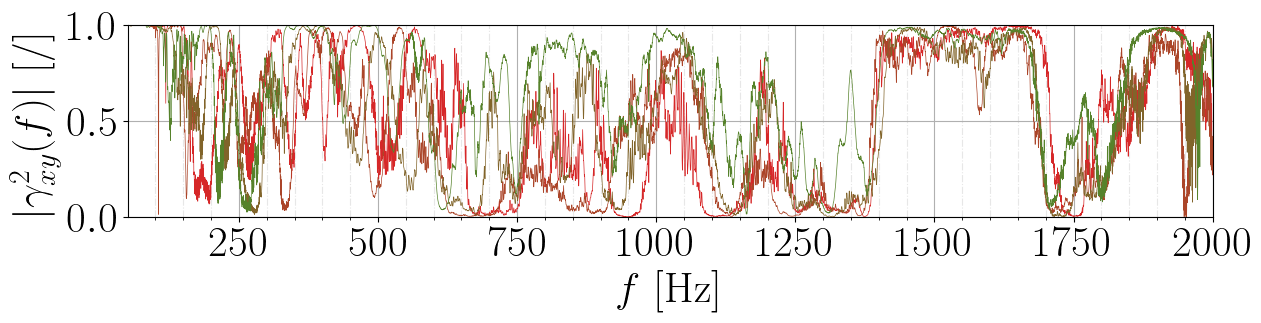

In [362]:
# Koherenca
plt.rcParams['figure.figsize'] = [14, 4]
plt.gcf().subplots_adjust(bottom=0.4)

i = 0

for data_j in data_group:
    
    dt = data_j.time()[0] 
    fs = data_j.time()[1]
    time = data_j.time()[2]
            
    t_start = time[-1]/10 #s
    t_step = time[-1]/1.1 #s
    
    g_input = data_j.instruments()[0]
    F_output = data_j.instruments()[1]

    # CSD
    xf, Pxy = signal.csd(g_input[t_1:t_2:], F_output[t_1:t_2:], fs, nperseg=fs*4)
    xf, Pxx = signal.csd(g_input[t_1:t_2:], g_input[t_1:t_2:], fs, nperseg=fs*4)
    xf, Pyy = signal.csd(F_output[t_1:t_2:], F_output[t_1:t_2:], fs, nperseg=fs*4)
    H1 = Pxy / Pxx
    H2 = Pyy / Pxy
    coh = H1/H2
    plt.plot(xf, np.abs(coh), linewidth=0.5, linestyle='-', alpha=1, label=f'MM {i+1}', color=colorFader(c1,c2, i/len(data_group)))
    
    i+=1
    
plt.xlim(50, 2000)
plt.ylim(0,1)
plt.xlabel(r'$f$ [Hz]')
plt.ylabel(r'$|\gamma^2_{xy}(f)|$ [/]')
plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
#plt.rcParams.update({'legend.labelspacing':0.05})
#plt.legend(ncol=1, prop={'size': 31})
plt.grid()
plt.grid(which='minor', linestyle = '-.', alpha=0.3)
#x_ticks = np.arange(50, 2000, 500)
#plt.xticks(x_ticks)
plt.savefig('koherenca_ROC3.pdf', format='pdf')
plt.show();